In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

us_holidays = holidays.US()

In [2]:
df = pd.read_csv("PJME_hourly.csv")

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [4]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

### Outliers

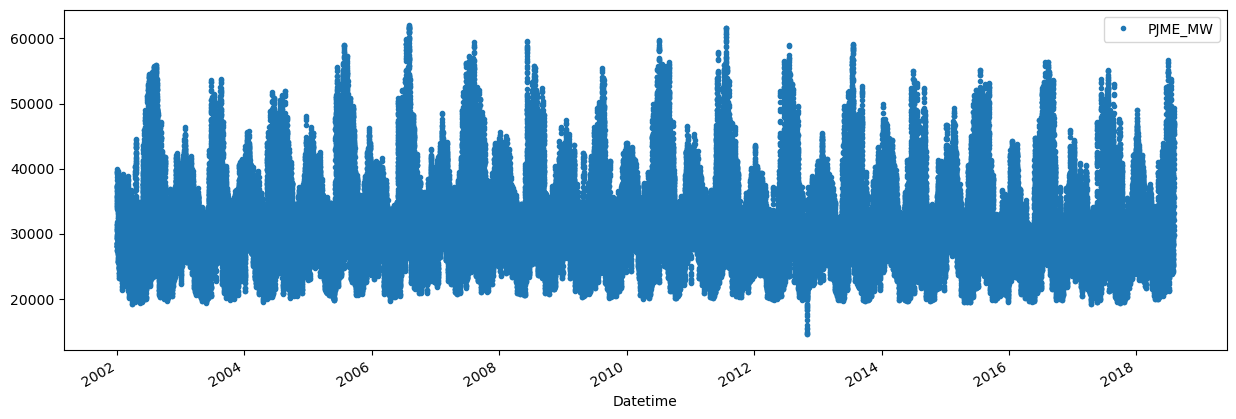

In [5]:
df.plot(style= '.', figsize=(15,5))
plt.show()

<Axes: xlabel='Datetime'>

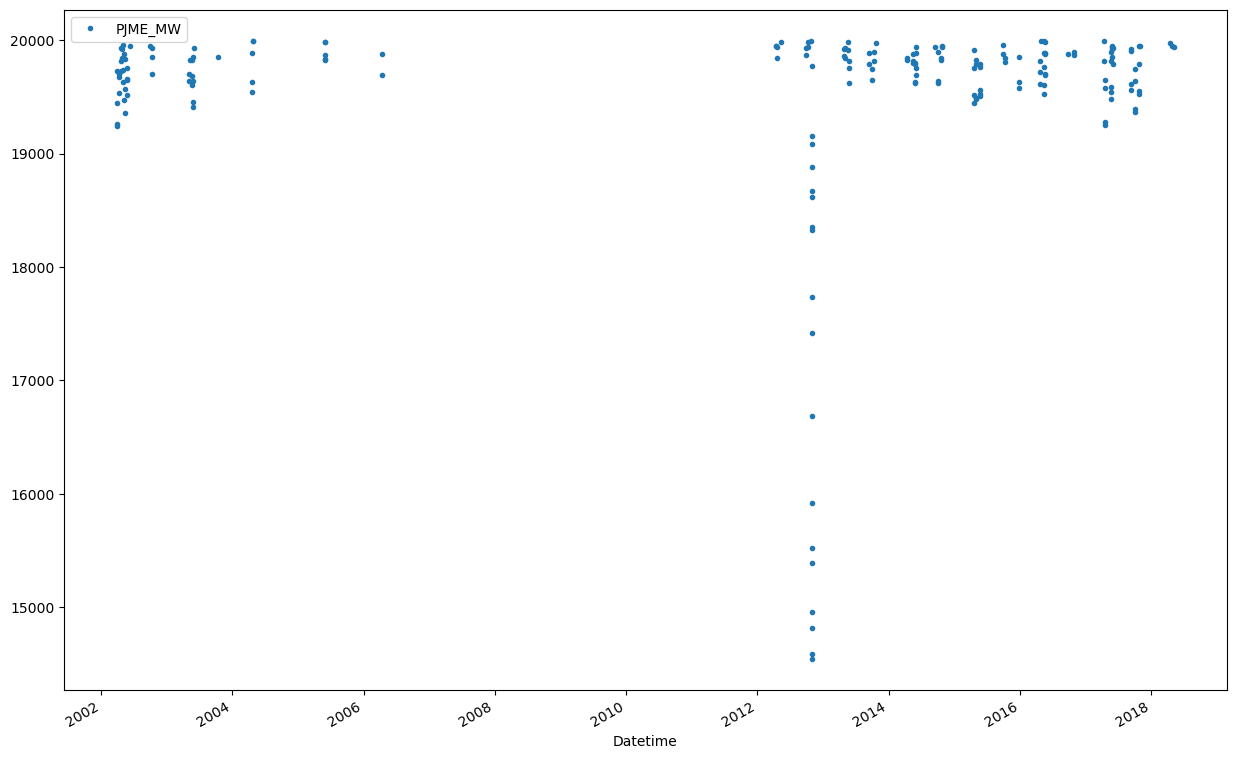

In [6]:
df.query('PJME_MW < 20000').plot(figsize=(15,10), style= '.')

In [7]:
# remove the outliers
df = df.query('PJME_MW > 19000').copy()

<Axes: xlabel='Datetime'>

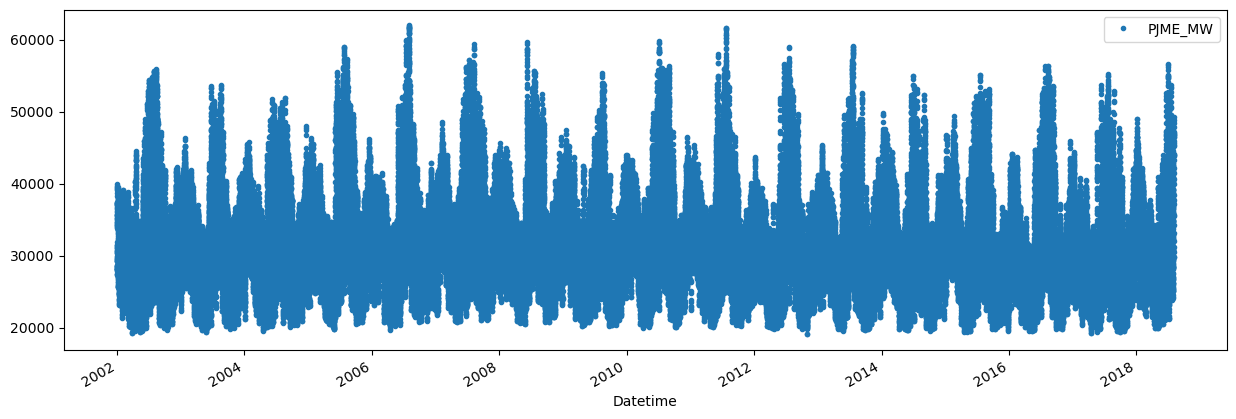

In [8]:
df.plot(style= '.', figsize=(15,5))

### Feature Engineering 

In [9]:
def feature_creation(df, target_col='PJME_MW') :
    # Create new features (Day of Week, Hour, Month, Year)
    # Time-based features
    df['Day of Week'] = df.index.dayofweek
    df['Hour'] = df.index.hour
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Holiday'] = df.index.map(lambda x: 1 if x in us_holidays else 0) # 1 for holiday 0 for not holiday

    # Lag Based Features
    df['Lag_1'] = df[target_col].shift(1) # 1 hour ago
    df['Lag_24'] = df[target_col].shift(24) # 1 day ago
    df['Lag_168'] = df[target_col].shift(168) # 1 week ago

    #Rolling Features
        #Daily rolling (24 hours)
    df['Rolling_mean_24'] = df[target_col].shift(1).rolling(window=24).mean()
    df['Rolling_std_24'] = df[target_col].shift(1).rolling(window=24).std()

        # Weekly rolling (168 hours)
    df['Rolling_mean_168'] = df[target_col].shift(1).rolling(window= 168).mean()
    df['Rolling_std_168'] = df[target_col].shift(1).rolling(window= 168).std()
    
    return df
df = feature_creation(df)
df.dropna(inplace=True)

In [10]:
df.head(
)

,PJME_MW,Day of Week,Hour,Month,Year,Quarter,Holiday,Lag_1,Lag_24,Lag_168,Rolling_mean_24,Rolling_std_24,Rolling_mean_168,Rolling_std_168
Datetime,,,,,,,,,,,,,,
2002-12-24 01:00:00,27213.0,1,1,12,2002,4,0,28570.0,27669.0,26498.0,29494.375,2721.798859,30890.333333,3484.998983
2002-12-24 02:00:00,25643.0,1,2,12,2002,4,0,27213.0,26162.0,25147.0,29475.375,2736.646326,30894.589286,3480.035908
2002-12-24 03:00:00,24907.0,1,3,12,2002,4,0,25643.0,25483.0,24574.0,29453.750,2765.861628,30897.541667,3475.337816
2002-12-24 04:00:00,24721.0,1,4,12,2002,4,0,24907.0,25045.0,24393.0,29429.750,2804.050165,30899.523810,3471.802781
2002-12-24 05:00:00,25144.0,1,5,12,2002,4,0,24721.0,25030.0,24860.0,29416.250,2826.766154,30901.476190,3468.212273


### Train Test Split

In [11]:
from sklearn.model_selection import TimeSeriesSplit

In [12]:
tss_week = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=168)
tss_month = TimeSeriesSplit(n_splits=5, test_size=24*30, gap= 168)
tss_year = TimeSeriesSplit(n_splits=5, test_size= 24*365, gap= 168)
df = df.sort_index()

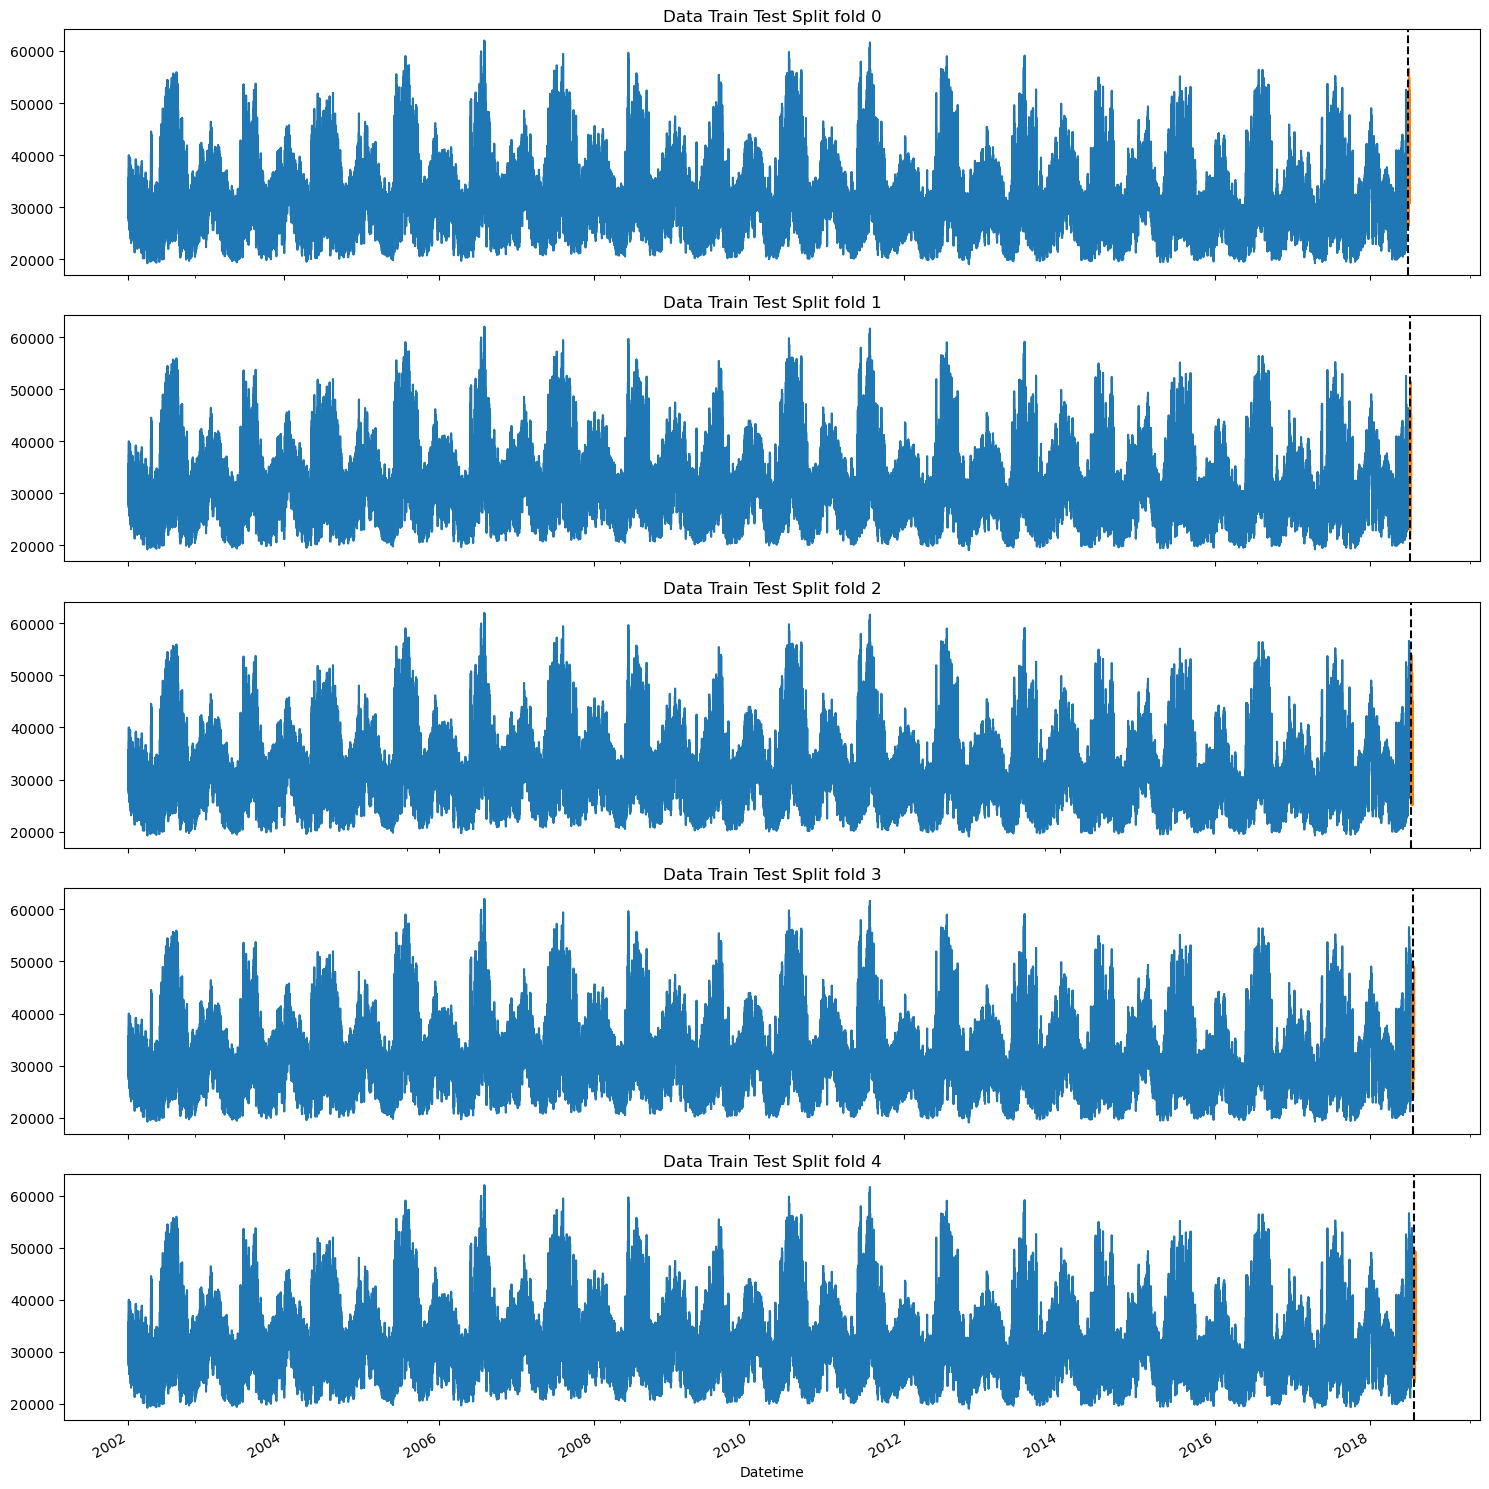

In [13]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0;
for train_idx, val_idx in tss_week.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # Visualize the train/test split
    train['PJME_MW'].plot(ax = axes[fold], label='Training Set')
    test['PJME_MW'].plot(ax= axes[fold], label='Test Split')
        
    axes[fold].axvline(x= test.index.min(), linestyle='--', color='black')
    # Set title for each subplot
    axes[fold].set_title(f'Data Train Test Split fold {fold}')
    fold += 1 

plt.tight_layout()
plt.show()

### Model Training

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
reg = xgb.XGBRegressor(n_estimators= 800, early_stopping_rounds= 50,
                       colsample_bytree=0.8,
                       base_score=0.5,
                       learning_rate = 0.05,   #  Tune the hyper peramaters
                       max_depth = 6,       # 5-10   6
                       subsample= 0.9,  #0.7 - 0.9 prevent overfitting
                       objective= 'reg:squarederror')

preds = []
scores = []

FEATURES = ['Day of Week', 'Hour', 'Month', 'Year', 'Quarter', 'Holiday', 'Lag_1', 'Lag_24', 'Lag_168',
           'Rolling_mean_24', 'Rolling_std_24', 'Rolling_mean_168', 'Rolling_std_168']
TARGET = ['PJME_MW']

for train_idx, val_idx in tss_week.split(df):
    # Create train and test data
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Model
    X_train, X_test = train[FEATURES], test[FEATURES]
    y_train, y_test = train[TARGET], test[TARGET]

    reg.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose= 100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:31064.41837	validation_1-rmse:40254.04398
[100]	validation_0-rmse:724.14035	validation_1-rmse:1064.68093
[200]	validation_0-rmse:584.75347	validation_1-rmse:848.45402
[300]	validation_0-rmse:536.37245	validation_1-rmse:789.53439
[400]	validation_0-rmse:504.39331	validation_1-rmse:772.08189
[500]	validation_0-rmse:483.58564	validation_1-rmse:751.50706
[600]	validation_0-rmse:467.30220	validation_1-rmse:736.53267
[700]	validation_0-rmse:453.37805	validation_1-rmse:722.92321
[799]	validation_0-rmse:440.55336	validation_1-rmse:716.40737
[0]	validation_0-rmse:31064.30264	validation_1-rmse:34207.23648
[100]	validation_0-rmse:722.85431	validation_1-rmse:1222.54618
[200]	validation_0-rmse:587.71190	validation_1-rmse:1024.44493
[300]	validation_0-rmse:541.16520	validation_1-rmse:970.86915
[400]	validation_0-rmse:509.85408	validation_1-rmse:924.26918
[500]	validation_0-rmse:487.84737	validation_1-rmse:896.85061
[600]	validation_0-rmse:470.48822	validation_1-rmse:870.70432
[

In [15]:
print(f"Scores across folds {np.mean(scores):0.4f}")
print(f"Fold scores: {scores}")

Scores across folds 768.7873
Fold scores: [np.float64(715.2935367735403), np.float64(844.3392016837782), np.float64(825.086359116426), np.float64(704.5091598056053), np.float64(754.708345985388)]


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

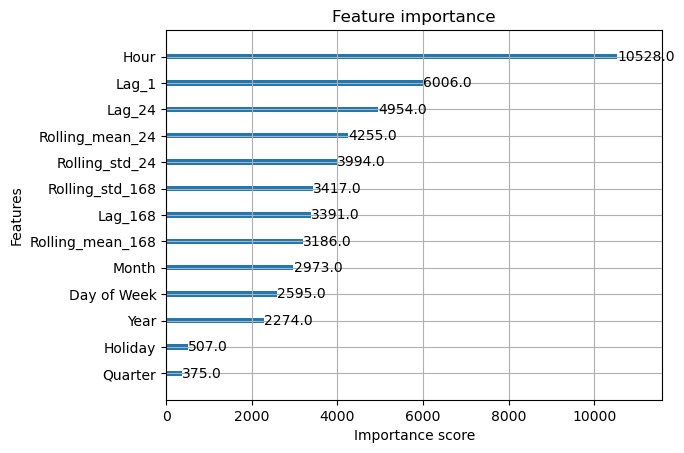

In [16]:
xgb.plot_importance(reg)

### Predict on all data

In [17]:
import xgboost as xgb

# Final dataset
df_final = df.copy().sort_index().dropna()
X_final = df_final[FEATURES]
y_final = df_final[TARGET]

# Final model
final_reg = xgb.XGBRegressor(
    n_estimators=800,
    n_jobs=1,
    random_state=30,
    colsample_bytree=0.8,
    base_score=0.5,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    objective='reg:squarederror'
)

# Train on all data
final_reg.fit(X_final, y_final, verbose=100)

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=1, num_parallel_tree=None, ...)

In [ ]:
y_in_sample = final_reg.predict(X_final)
rmse_in = np.sqrt(mean_squared_error(y_final, y_in_sample))
print(f"In-sample RMSE: {rmse_in:.2f}  (optimistic; use CV for real eval)")

In-sample RMSE: 442.73  (optimistic; use CV for real eval)


### Save model 

In [19]:
final_reg.save_model("final_model.json")